In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

### Data

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import time
from matplotlib.lines import Line2D
import PIL.Image

In [3]:
from utils.dataset import get_dataset_by_name
# Data, modelling and hyperparameters setup

dataset_name = 'personalized-pricing'
dataset = get_dataset_by_name(dataset_name)
actions, features, losses, propensities, potentials = dataset.sample_logged_data(n_samples=1000)

In [4]:
def get_standardized(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def plot_dataset(features, potentials, dataset_name):

    # Utilities
    colormap = cm.get_cmap('PRGn')
    custom_lines_p = [Line2D([0], [0], color=colormap(0.), lw=4),
                Line2D([0], [0], color=colormap(.5), lw=4),
                Line2D([0], [0], color=colormap(1.), lw=4)]
    fig = plt.figure(figsize=(9, 6))
    
    
    # Original data
    standardized_potentials = get_standardized(potentials)
    plt.scatter(features[:, 0], features[:, 1], s=10, color=colormap(standardized_potentials))

    plt.text(.99, .01, dataset_name,
             transform=plt.gca().transAxes, 
             size=15,
             horizontalalignment='right')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
#     axs[0].set_xlim(-0.2,1.2)
#     axs[0].set_ylim(-0.2,1.2)

    plt.title('Ground truth data')
    plt.legend(custom_lines_p, ['Low', 'Medium', 'High'], title='$p \sim P \ | \ X$', loc="upper right",
              fancybox=True)
    plt.show()
    


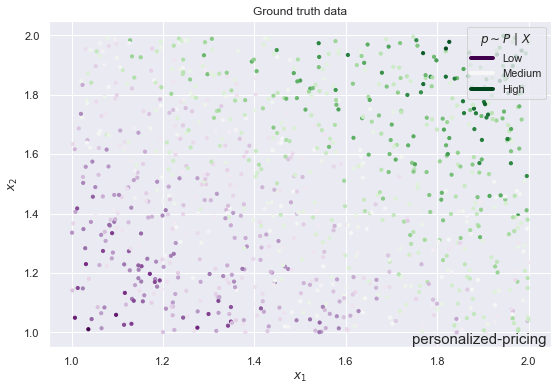

In [5]:
plot_dataset(features, potentials, dataset_name)

In [6]:
class LossHistory(object):
    
    def __init__(self, name):
        self.name = name
        self.crm_loss = []
        self.online_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.rewards = []
        
    def update(self, beta, online_loss, crm_loss, n_samples):
        self.betas += [beta]
        self.online_loss += [online_loss]
        self.crm_loss += [crm_loss]
        self.n_samples += [n_samples]
        
    def show_last(self):
        print(
            '<', self.name,
            'CRM loss: %.5f' % self.crm_loss[-1],
            'Online loss: %.5f' % self.online_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % sum(self.n_samples),
            '>',
            file=sys.stderr
        )

In [19]:
class Model():
    
    def __init__(self, name, random_seed):
        self.name = name
        self.rng = np.random.RandomState(random_seed)
    
    def create_start_parameter(self, dataset):
        d = dataset.dimension
        if self.name == 'linear':
#             return self.rng.normal(scale=0.1, size=d + 2)
            return self.rng.normal(scale=0.1, size=d + 1)

        elif self.name == 'polynomial':
            return self.rng.normal(scale=0.1, size=d ** 2 + d + 2)
        else:
            return

    def _linear_modelling(self, parameter, features):
#         intercept_coeff, mean_coeff, var = parameter[0], parameter[1:-1], parameter[-1]
        intercept_coeff, mean_coeff = parameter[0], parameter[1:]
        mean = jnp.dot(features, mean_coeff) + intercept_coeff
        return mean, None
    
    def _polynomial_modelling(self, parameter, features):
        n = features.shape[1]
        intercept, coeff_lin, coeff_kern, var = parameter[0], parameter[1:n + 1], parameter[n + 1:-1], parameter[-1]
        m_linear = jnp.dot(features, coeff_lin) + intercept
        f = jnp.einsum('ij,ih->ijh', features, features).reshape(features.shape[0], -1)
        m_kern = jnp.dot(f, coeff_kern)
        mean = m_kern + m_linear
        return mean, var
    
    def get_parameter(self, parameter, features):
        if self.name == 'linear':
            return self._linear_modelling(parameter, features)
        elif self.name == 'polynomial':
            return self._polynomial_modelling(parameter, features)
        else:
            return  

        

In [20]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

class Estimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        
    def objective_function(self, param, actions, contexts, losses, propensities):
        
        contextual_param, _ = self.contextual_modelling.get_parameter(param, contexts)
        propensities = jnp.clip(propensities, 1e-5, None)
        importance_weights = pdf(contextual_param, actions)/propensities
        mean = jnp.mean(losses * importance_weights)
        std = jnp.std(losses * importance_weights)
        return mean + self.lbd * std
    
    
def optimize(loss_fun, init_parameter, args):

    lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B").run(init_parameter, *args)
    lbfgs_sol = lbfgsb.params
    lbfgs_fun_val = lbfgsb.state.fun_val
    
    return lbfgs_sol, lbfgs_fun_val

# Experiment

In [21]:
logging_mu = 3
logging_scale = 0.3


def get_logging_data(n_samples, dataset, random_seed=123):

    actions, contexts, losses, propensities, potentials = dataset.sample_logged_data(n_samples)
#     losses = -rewards
#     loss = np.mean(losses)
# #     epsilon = 0.9
# #     logging_loss_threshold = loss*(1+epsilon)
    logging_data = actions, contexts, losses, propensities

    return logging_data


In [22]:
import os


def online_evaluation(optimized_param, contextual_modelling, dataset, random_seed):
    
    rng = np.random.RandomState(random_seed)
    contexts, potentials = dataset.test_data
    contextual_param, _ = contextual_modelling.get_parameter(optimized_param, contexts)
    size = contexts.shape[0]
    rewards = []
    
    for i in range(10):
        sampled_actions = rng.normal(contextual_param, logging_scale, size)
        rewards += [- dataset.get_losses_from_actions(potentials, sampled_actions)]
        
    rewards_array = np.stack(rewards, axis=0)
    var_pi = np.mean(np.var(rewards_array, axis=0))
    var_context = np.var(np.mean(rewards_array, axis=1))
    return - np.mean(rewards_array), np.std(np.mean(rewards_array, axis=0))
    
def start_experiment(random_seed, dataset, name):
    print(
        '***', 'EXPERIMENT', name,
        'Random seed: %i' % random_seed,
        'Dataset: %s' % dataset.name,
        '***',
        file=sys.stderr
    )

In [23]:
M = 10
n_0 = 10
T = n_0 * (2**(M+1)-1)

In [24]:
T

20470

### Single round CRM

In [30]:
betas = []
single_crm_losses = []
single_online_losses = []


dataset_name = 'personalized-pricing'
settings = {
    'lambda': 0.1,
    'contextual_modelling': 'linear'
}



def crm_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, 'CRM')
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])

    n_samples = T
    
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    optimized_mus = [mu]
    logging_data = get_logging_data(n_samples, dataset, random_seed)
    
    # Optimization 
    init_parameter = jnp.array(mu, dtype='float32')
    
    actions, contexts, losses, propensities = logging_data 
    contextual_param, _ = estimator.contextual_modelling.get_parameter(mu, contexts)
    poilicy = pdf(contextual_param, actions)
    
    args = logging_data
    optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)
    
    # Evaluation
    single_crm_loss = loss_crm._value
    mu = optimized_mu._value
    single_online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
    
    return single_crm_loss, single_online_loss


for random_seed in range(10):
    crm_loss, online_loss = crm_experiment(random_seed, dataset_name, settings)
    single_crm_losses.append(crm_loss)
    single_online_losses.append(online_loss)


single_crm_loss, single_crm_loss_std = np.mean(single_crm_losses), np.std(single_crm_losses)
single_online_loss, single_online_loss_std = np.mean(single_online_losses), np.std(single_online_losses)

*** EXPERIMENT CRM Random seed: 0 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 1 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 2 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 3 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 4 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 5 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 6 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 7 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 8 Dataset: personalized-pricing ***
*** EXPERIMENT CRM Random seed: 9 Dataset: personalized-pricing ***


In [26]:
single_online_loss, single_online_loss_std

(-5.62515452317733, 0.04756144312450067)

In [27]:
single_online_loss

-5.62515452317733

In [28]:
mu.shape

(11,)

In [31]:
optimal_mu = dataset.get_optimal_parameter()
contextual_modelling = Model(settings['contextual_modelling'], 42)
online_evaluation(mu, contextual_modelling, dataset, 42)

(-5.740335925567532, 1.9305577466773791)

In [32]:
online_evaluation(mu, contextual_modelling, dataset, 42)

(-5.736977490337821, 1.931110636172069)

In [33]:
optimal_mu, mu

(array([ 2.97608447e-06,  5.55554884e-01,  5.55554891e-01,  5.55554885e-01,
         1.54874224e-08,  1.01140335e-08,  1.36779433e-08, -8.47424618e-09,
        -1.38412932e-08,  5.24643553e-09,  4.44893345e-09]),
 array([ 3.05673627e-06,  5.55554879e-01,  5.55554876e-01,  5.55554903e-01,
        -1.17096931e-08,  2.87415825e-09,  4.07573609e-09,  3.30053405e-09,
         3.84382807e-09,  1.47658616e-09, -3.47777484e-08]))

In [ ]:
contexts, potentials = dataset.test_data
contextual_optimal_param, _ = contextual_modelling.get_parameter(optimal_mu, contexts)
contextual_param, _ = contextual_modelling.get_parameter(mu, contexts)

sampled_actions = rng.normal(contextual_param, logging_scale, size)
pdf(contextual_param, actions)

### Sequential CRM - Myopic

In [ ]:
histories = []


def scrm_myopic_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'SCRM Myopic')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_m_loss_history = LossHistory("SCRM-M")

    n_samples = 10
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset, random_seed)
    rng = np.random.RandomState(random_seed)

    for m in range(M):

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        

        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        
        n_samples *= 2
        contexts, potentials = dataset.sample_data(n_samples)
        contextual_param, _ = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities

        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
        scrm_m_loss_history.update(optimized_mu, online_loss, loss_crm, n_samples)
        scrm_m_loss_history.show_last()
    
    return scrm_m_loss_history

for random_seed in range(10):
    scrm_m_loss_history = scrm_myopic_experiment(random_seed, dataset_name, settings)
    histories.append(scrm_m_loss_history)
    

In [ ]:
scrm_m_losses = np.array([scrm_m_loss_history.crm_loss for scrm_m_loss_history in histories])
mean_scrm_m_losses = np.mean(scrm_m_losses, axis=0)

scrm_m_online_losses = np.array([scrm_m_loss_history.online_loss for scrm_m_loss_history in histories])
mean_scrm_m_online_losses = np.mean(scrm_m_online_losses, axis=0)

## Sequential with past information

### Naive Multi IPS

In [ ]:
### Utilities

def get_all_data(logging_actions, logging_contexts, logging_losses, logging_propensities):
    all_logging_actions = np.concatenate(logging_actions)
    all_logging_contexts = np.concatenate(logging_contexts)
    all_logging_losses = np.concatenate(logging_losses)
    all_logging_propensities = np.concatenate(logging_propensities)
    return all_logging_actions, all_logging_contexts, all_logging_losses, all_logging_propensities

def update_past_data(data, samples):
    return np.hstack([data, samples])

In [ ]:
histories = []

def scrm_nmips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Naive MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_nmips_loss_history = LossHistory("SCRM-NMIPS")
    
    n_samples = 10
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset, random_seed)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    all_actions, all_contexts, all_losses, all_propensities = logging_data

    for m in range(M):

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, all_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        
        contexts, potentials = dataset.sample_data(n_samples)
        contextual_param, _ = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
        scrm_nmips_loss_history.update(optimized_mu, online_loss, loss_crm, n_samples)
        scrm_nmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        
    return scrm_nmips_loss_history

for random_seed in range(10):
    scrm_nmips_loss_history = scrm_nmips_experiment(random_seed, dataset_name, settings)
    histories.append(scrm_nmips_loss_history)
        

In [ ]:
scrm_nmips_losses = np.array([scrm_nmips_loss_history.crm_loss for scrm_nmips_loss_history in histories])
mean_scrm_nmips_losses = np.nanmean(scrm_nmips_losses, axis=0)

scrm_nmips_online_losses = np.array([scrm_nmips_loss_history.online_loss for scrm_nmips_loss_history in histories])
mean_scrm_nmips_online_losses = np.nanmean(scrm_nmips_online_losses, axis=0)

### Multi data 

In [ ]:
### Multiple IPS

def get_omega_weights(params, all_actions, all_contexts, all_propensities):
    distributions = []
    for param in params:
        contextual_param, _ = linear_modelling(param, all_contexts)
        distributions.append(norm(loc=contextual_param, scale=logging_scale).pdf)
    pi_t = np.array([distribution(all_actions) for distribution in distributions])
    n_pi_t = n_samples * pi_t
    sum_n_pi_t = np.sum(n_pi_t, axis=0)
    all_omegas = all_propensities / sum_n_pi_t
    return all_omegas

def multi_ips_mean(param, all_actions, all_contexts, all_losses, all_propensities, all_omegas):
    
    # Importance weights
    contextual_param, _ = linear_modelling(param, all_contexts)
    importance_weights = pdf(contextual_param, all_actions)/all_propensities
    all_importance_weights = pdf(contextual_param, all_actions)/all_propensities
    
    # Omega weight
    return np.sum(all_omegas * all_losses * all_importance_weights)

class MixtureEstimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        self.params = []
        self.rollouts_n_samples = []
        
    def get_mixture_logging_propensities(self, all_policy_samples, all_contexts):
        distributions = []

        for param in self.params:
            contextual_param, _ = self.contextual_modelling.get_parameter(param, all_contexts)
            distributions.append(norm(loc=contextual_param, scale=logging_scale).pdf)
        pi_t = np.array([distribution(all_policy_samples) for distribution in distributions])
        alpha_t = self.rollouts_n_samples/ np.sum(self.rollouts_n_samples)
        mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
        return mixture_logging_propensities
        
    def objective_function(self, param, actions, contexts, losses, mixture_propensities):
        contextual_param, _ = self.contextual_modelling.get_parameter(param, contexts)
        mixture_propensities = jnp.clip(mixture_propensities, 1e-5, None)
        mixture_importance_weights = pdf(contextual_param, actions)/mixture_propensities
        mixture_mean = jnp.mean(losses * mixture_importance_weights)
        mixture_std = jnp.sqrt(jnp.sum(jnp.cov(losses * mixture_importance_weights)))
        return mixture_mean + self.lbd * mixture_std
    
    def update(self, param, rollout_n_samples):
        self.params.append(param)
        self.rollouts_n_samples = np.concatenate([self.rollouts_n_samples, [[rollout_n_samples]]], axis=0)



In [ ]:
histories = []

def scrm_mixture_mips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Mixture MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = MixtureEstimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_mmips_loss_history = LossHistory("SCRM-MMIPS")
    
    n_samples = 10
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset, random_seed)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    estimator.params.append(mu)
    estimator.rollouts_n_samples = np.array([[n_samples]])
    all_actions, all_contexts, all_losses, all_propensities = logging_data

    for m in range(M):

        mixture_logging_propensities = estimator.get_mixture_logging_propensities(all_actions, all_contexts)

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, mixture_logging_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        estimator.update(optimized_mu, n_samples)
        
        contexts, potentials = dataset.sample_data(n_samples)
        contextual_param, _ = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
        scrm_mmips_loss_history.update(optimized_mu, online_loss, loss_crm, n_samples)
        scrm_mmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        
    return scrm_mmips_loss_history

for random_seed in range(10):
    scrm_mmips_loss_history = scrm_mixture_mips_experiment(random_seed, dataset_name, settings)
    histories.append(scrm_mmips_loss_history)
        


In [ ]:
scrm_mmips_losses = np.array([scrm_mmips_loss_history.crm_loss for scrm_mmips_loss_history in histories])
mean_scrm_mmips_losses = np.nanmean(scrm_mmips_losses, axis=0)

scrm_mmips_online_losses = np.array([scrm_mmips_loss_history.online_loss for scrm_mmips_loss_history in histories])
mean_scrm_mmips_online_losses = np.nanmean(scrm_mmips_online_losses, axis=0)

### Plot results

In [ ]:
single_crm_loss_ = single_crm_loss * np.ones_like(mean_scrm_m_losses)
single_online_loss_ = single_online_loss * np.ones_like(mean_scrm_m_losses)

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(single_crm_loss_, '--', label='CRM')
ax.plot(mean_scrm_m_losses, '--', label='SCRM-M')
ax.plot(mean_scrm_nmips_losses, '--', label='SCRM-NMIPS')
ax.plot(mean_scrm_mmips_losses, '--', label='SCRM-MMIPS')
ax.set_ylim(-0.8, -0.4)
ax.legend(loc='upper right')

ax2.plot(single_online_loss_, '-', label='CRM')
ax2.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax2.plot(mean_scrm_nmips_online_losses, '-.', label='SCRM-NMIPS')
ax2.plot(mean_scrm_mmips_online_losses,'-.', label='SCRM-MMIPS')
ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
ax2.plot(batch_sbpe_online_losses, label='SBPE')

ax2.set_ylabel('Online Loss')
ax2.legend(loc='upper right')

# Batch bandits

In [ ]:
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(gamma, x, y):
    return jnp.exp( - gamma * sqeuclidean_distance(x, y))

# Exponential Kernel
@jax.jit
def exp_kernel(gamma, x, y):
    return jnp.exp( - gamma * jnp.sqrt(sqeuclidean_distance(x, y)))

@jax.jit
def polynomial_kernel(dimension, x, y):
    return (jnp.dot(x,y)+1)**dimension

def gram(func, params, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(params, x1, y1))(y))(x)

class Kernel:

    def __init__(self, settings):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self._param = 0.1

    def gram_matrix(self, states):
        return self._pairwise(states, states)

    def evaluate(self, state1, state2):
        return self._pairwise(state1, state2)

    def _pairwise(self, X1, X2):
        pass


class Gaussian(Kernel):

    def __init__(self, *args):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        super(Gaussian, self).__init__(*args)
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self._std = self._param

    def _pairwise(self, X1, X2):
        """
        Args:
            X1 (np.ndarray)
            X2 (np.ndarray)
        """
        return gram(rbf_kernel, 1/(2* self._std ** 2),X1,X2)

class Exponential(Kernel):

    def __init__(self, *args):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        super(Exponential, self).__init__(*args)
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self._alpha = 10

    def _pairwise(self, X1, X2):
        """
        Args:
            X1 (np.ndarray)
            X2 (np.ndarray)
        """
        return gram(exp_kernel, self._alpha,X1,X2)
    
class Polynomial(Kernel):

    def __init__(self, *args):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        super(Polynomial, self).__init__(*args)
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self._dimension = 2

    def _pairwise(self, X1, X2):
        """
        Args:
            X1 (np.ndarray)
            X2 (np.ndarray)
        """
        return gram(polynomial_kernel, self._dimension, X1,X2)
    
class KernelUCB:

    def __init__(self, settings, kernel):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self.rng = np.random.RandomState(123)
        self.reg_lambda = settings['reg_lambda']
        self.kernel = kernel
        self.settings = settings

    def get_story_data(self):
        return self.past_states, self.rewards

    def set_gram_matrix(self):
        K = self.kernel.gram_matrix(self.past_states)
        K += self.reg_lambda * jnp.eye(K.shape[0])
        self.K_matrix_inverse = jnp.linalg.inv(K)
        
    def instantiate(self, env):
        self.action_anchors = env.get_anchor_points()
        context, label = env.sample_data(n=1)
        idx = self.rng.choice(self.action_anchors.shape[0])
        action = np.array([self.action_anchors[idx]])
        state = self.get_state(context, action)
        reward = env.sample_reward(action, label)
        self.past_states = jnp.array(self.get_state(context, action))
        self.rewards = jnp.array([reward])
        self.set_gram_matrix()
        
    def set_beta(self):
        self.beta_t = 0.1

    def get_upper_confidence_bound(self, state, K_matrix_inverse, S, rewards):
        K_S_s = self.kernel.evaluate(S, state)
        mean = jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, rewards))
        K_ss = self.kernel.evaluate(state, state)
        std = (1/self.reg_lambda)*(K_ss - jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, K_S_s)))
        ucb = mean + self.beta_t * jnp.sqrt(std)
        return jnp.squeeze(ucb)

    def sample_action(self, context):
        self.set_beta()
        S, rewards = self.get_story_data()
        args = self.K_matrix_inverse, S, rewards
        return self.continuous_inference(context, args)

    def continuous_inference(self, context, args):
        nb_gradient_steps = 0
        if nb_gradient_steps == 0:
            return self.discrete_inference(context,args)
        else:
            def func(action):
                state = self.get_state(context, action)
                return self.get_upper_confidence_bound(state, *args)

            a0 = self.discrete_inference(context, args)
            max_hessian_eigenvalue = jnp.max(jsp.linalg.eigh(hessian(func)(a0), eigvals_only=True))
            step_size = jnp.nan_to_num(1 / max_hessian_eigenvalue)
            a_t = a0
            for _ in range(nb_gradient_steps):
                gradient = jnp.nan_to_num(grad(func)(a_t))
                a_t -= step_size * gradient
            return a_t

    def get_state(self, context, action):
        context, action = context.reshape((1, -1)), action.reshape((1, -1))
        return jnp.concatenate([context, action], axis=1)

    def get_ucb_actions(self, context, grid, args):
        return jnp.array([self.get_upper_confidence_bound(self.get_state(context, a), *args) for a in grid])

    def discrete_inference(self, context, args):
        grid = self.action_anchors
        ucb_all_actions = self.get_ucb_actions(context,grid,args) 
        idx = jnp.argmax(ucb_all_actions)
        grid = jnp.array(grid)
        return jnp.array([grid[idx]])

    def update_data_pool(self, context, action, reward):
        state = self.get_state(context, action)
        self.past_states = jnp.concatenate([self.past_states, state])
        self.rewards = jnp.concatenate([self.rewards, jnp.array([reward])])

    def update_agent(self, context, action, reward):
        state = self.get_state(context, action)
        S, _ = self.get_story_data()
        self.K_matrix_inverse = self.efficient_update_gram_matrix(S, state, self.K_matrix_inverse)
        self.update_data_pool(context, action, reward)

    def efficient_update_gram_matrix(self, S, state, K_matrix_inverse):
        K_S_s = self.kernel.evaluate(S, state)
        K_ss = self.kernel.evaluate(state, state)
        s = K_ss + self.reg_lambda - jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, K_S_s))
        Z_12 = - 1/s * (jnp.dot(K_matrix_inverse, K_S_s))
        Z_21 =  - 1/s * (jnp.dot(K_S_s.T, K_matrix_inverse))
        Z_11 = K_matrix_inverse + s * jnp.dot(Z_12, Z_21)
        K_matrix_inverse = jnp.block([[Z_11, Z_12], [Z_21, 1/s]])
        return K_matrix_inverse
    
class BatchKernelUCB:

    def __init__(self, settings, kernel):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self.rng = np.random.RandomState(123)
        self.reg_lambda = settings['reg_lambda']
        self.kernel = kernel
        self.settings = settings
        self.name = 'Batch-KUCB'

    def get_story_data(self):
        return self.past_states, self.past_rewards

    def set_gram_matrix(self):
        K = self.kernel.gram_matrix(self.past_states)
        K += self.reg_lambda * jnp.eye(K.shape[0])
        self.K_matrix_inverse = jnp.linalg.inv(K)
        
    def instantiate(self, env):
        self.action_anchors = env.get_anchor_points()
        actions, contexts, rewards = env.get_logging_data()
        states = self.get_states(contexts, actions)
        self.past_states = jnp.array(states)
        self.past_rewards = jnp.expand_dims(jnp.array(rewards), axis=1)
        self.set_gram_matrix()
        
    def set_beta(self):
        self.beta_t = 0.1

    def get_upper_confidence_bound(self, states, K_matrix_inverse, S, past_rewards):
        K_S_s = self.kernel.evaluate(S, states)
        mean = jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, past_rewards))
        K_ss = self.kernel.evaluate(states, states)
        std = np.diag((1/self.reg_lambda)*(K_ss - jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, K_S_s))))
        ucb = jnp.squeeze(mean) + self.beta_t * jnp.sqrt(std)
        return ucb

    def sample_actions(self, contexts):
        self.set_beta()
        S, rewards = self.get_story_data()
        args = self.K_matrix_inverse, S, rewards
        return self.continuous_inference(contexts, args)

    def continuous_inference(self, contexts, args):
        nb_gradient_steps = 0
        if nb_gradient_steps == 0:
            return self.discrete_inference(contexts, args)
        else:
            def func(action):
                state = self.get_state(contexts, action)
                return self.get_upper_confidence_bound(state, *args)

            a0 = self.discrete_inference(contexts, args)
            max_hessian_eigenvalue = jnp.max(jsp.linalg.eigh(hessian(func)(a0), eigvals_only=True))
            step_size = jnp.nan_to_num(1 / max_hessian_eigenvalue)
            a_t = a0
            for _ in range(nb_gradient_steps):
                gradient = jnp.nan_to_num(grad(func)(a_t))
                a_t -= step_size * gradient
            return a_t

    def get_states(self, contexts, actions):
        batch_size = contexts.shape[0]
        contexts, actions = contexts.reshape((batch_size, -1)), actions.reshape((batch_size, 1))
        return jnp.concatenate([contexts, actions], axis=1)

    def get_ucb_actions(self, contexts, grid, args):
        return jnp.transpose(jnp.array([self.get_upper_confidence_bound(self.get_states(contexts, a*np.ones((contexts.shape[0]))), *args) for a in grid]))

    def discrete_inference(self, contexts, args):
        grid = self.action_anchors
        ucb_all_actions = self.get_ucb_actions(contexts, grid, args) 
        idx = jnp.argmax(ucb_all_actions, axis=1)
        grid = jnp.array(grid)
        return jnp.array([grid[idx]])

    def update_data_pool(self, contexts, actions, rewards):
        states = self.get_states(contexts, actions)
        rewards = np.expand_dims(rewards, axis=1)
        self.past_states = jnp.concatenate([self.past_states, states])
        self.past_rewards = jnp.concatenate([self.past_rewards, rewards])

    def update_agent(self, contexts, actions, rewards):
        self.update_data_pool(contexts, actions, rewards)
        self.set_gram_matrix()

class SBPE:

    def __init__(self, settings, kernel):
        """Initializes the class

        Attributes:
            random_seed (int):  random seed for data generation process

        """
        self.rng = np.random.RandomState(123)
        self.reg_lambda = settings['reg_lambda']
        self.kernel = kernel
        self.settings = settings
        self.name = 'SBPE'

    def get_story_data(self):
        return self.past_states, self.past_rewards

    def set_gram_matrix(self):
        K = self.kernel.gram_matrix(self.past_states)
        K += self.reg_lambda * jnp.eye(K.shape[0])
        self.K_matrix_inverse = jnp.linalg.inv(K)
        
    def instantiate(self, env):
        self.action_anchors = env.get_anchor_points()
        actions, contexts, rewards = env.get_logging_data()
        states = self.get_states(contexts, actions)
        self.past_states = jnp.array(states)
        self.past_rewards = jnp.expand_dims(jnp.array(rewards), axis=1)
        self.set_gram_matrix()
        
    def set_beta(self):
        self.beta_t = 0.1

    def pure_exploitations(self, states, K_matrix_inverse, S, past_rewards):
        K_S_s = self.kernel.evaluate(S, states)
        return jnp.squeeze(jnp.dot(K_S_s.T, jnp.dot(K_matrix_inverse, past_rewards)))

    def sample_actions(self, contexts):
        S, rewards = self.get_story_data()
        args = self.K_matrix_inverse, S, rewards
        return self.continuous_inference(contexts, args)

    def continuous_inference(self, contexts, args):
        nb_gradient_steps = 0
        if nb_gradient_steps == 0:
            return self.discrete_inference(contexts, args)
        else:
            def func(action):
                state = self.get_state(contexts, action)
                return self.get_upper_confidence_bound(state, *args)

            a0 = self.discrete_inference(contexts, args)
            max_hessian_eigenvalue = jnp.max(jsp.linalg.eigh(hessian(func)(a0), eigvals_only=True))
            step_size = jnp.nan_to_num(1 / max_hessian_eigenvalue)
            a_t = a0
            for _ in range(nb_gradient_steps):
                gradient = jnp.nan_to_num(grad(func)(a_t))
                a_t -= step_size * gradient
            return a_t

    def get_states(self, contexts, actions):
        batch_size = contexts.shape[0]
        contexts, actions = contexts.reshape((batch_size, -1)), actions.reshape((batch_size, 1))
        return jnp.concatenate([contexts, actions], axis=1)

    def get_exploitations(self, contexts, grid, args):
        return jnp.transpose(jnp.array([self.pure_exploitations(self.get_states(contexts, a*np.ones((contexts.shape[0]))), *args) for a in grid]))

    def discrete_inference(self, contexts, args):
        grid = self.action_anchors
        exploitations_all_actions = self.get_exploitations(contexts, grid, args) 
        idx = jnp.argmax(exploitations_all_actions, axis=1)
        grid = jnp.array(grid)
        return jnp.array([grid[idx]])

    def update_data_pool(self, contexts, actions, rewards):
        states = self.get_states(contexts, actions)
        rewards = np.expand_dims(rewards, axis=1)
        self.past_states = jnp.concatenate([self.past_states, states])
        self.past_rewards = jnp.concatenate([self.past_rewards, rewards])

    def update_agent(self, contexts, actions, rewards):
        self.update_data_pool(contexts, actions, rewards)
        self.set_gram_matrix()



In [ ]:


from tqdm import tqdm

class Environment:

    def __init__(self, dataset, n_logging_samples):
        self.dataset = dataset
        self.n_logging_samples = n_logging_samples

    def sample_data(self, n):
        return self.dataset.sample_data(n_samples=n)

    def sample_reward(self, actions, labels):
        actions = np.squeeze(actions)
        return - self.dataset.get_losses_from_actions(labels, actions)

    def get_anchor_points(self):
        return np.arange(-10, 10, 0.5)
    
    def get_logging_data(self):
        actions, contexts, losses, _, _, _ = self.dataset.sample_logged_data(self.n_logging_samples)
        return actions, contexts, -losses


def instantiate_metrics():
    return {
        'time': [],
        'average_reward': [],
        'regret': [],
    }



In [ ]:
settings = {
    'agent': 'k_ucb',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1,
    'expname': 'experiment_k_ucb'
}

n_logging_samples = 10
M = 8

def batch_bandit_experiment(random_seed, dataset_name, settings, agent):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, agent.name)
    
    # Model setting
    env = Environment(dataset, n_logging_samples)
    kernel = Polynomial(settings)
    agent.instantiate(env)
    metrics = instantiate_metrics()
    best_strategy_rewards = []

    t0 = time.time()

    batch_size = n_logging_samples
    for step in tqdm(range(M)):

        # choose a random context.
        batch_size *= 2
        contexts, labels = env.sample_data(n=batch_size)
        # iterate learning algorithm for 1 round.
        actions = agent.sample_actions(contexts)
        rewards = env.sample_reward(actions, labels)

        agent.update_agent(contexts, actions, rewards)
        # get best_strategy's reward for the current context.
    #     best_strategy_rewards.append(env.get_best_reward_in_context(context, label))
        t = time.time() - t0
        metrics['time'].append(t)
        average_reward = np.mean(agent.past_rewards[1:])
        metrics['average_reward'].append(average_reward)
    #         sum_best = np.sum(np.array(best_strategy_rewards))
        sum_agent = np.sum(np.array(agent.past_rewards[1:]))
    #         regret = sum_best - sum_agent
        print('Average reward: {}'.format(average_reward))
#         print('Regret: {}'.format(regret))

    batch_online_losses = np.array([-average_reward._value for average_reward in metrics['average_reward']])

    return np.expand_dims(batch_online_losses, axis=0)


agent = BatchKernelUCB(settings, kernel)
batch_bandit_online_losses = []

for random_seed in range(10):
    batch_bandit_online_losses.append(batch_bandit_experiment(random_seed, dataset_name, settings, agent))

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses, axis=0)
batch_kucb_online_losses, batch_k_ucb_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)

In [ ]:
settings = {
    'agent': 'k_ucb',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1,
    'expname': 'experiment_k_ucb'
}
M = 8

kernel = Polynomial(settings)
agent = SBPE(settings, kernel)
batch_bandit_online_losses = []

for random_seed in range(10):
    batch_bandit_online_losses.append(batch_bandit_experiment(random_seed, dataset_name, settings, agent))

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses)
batch_sbpe_online_losses, batch_sbpe_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)